# Going To The Movies

(Final Project of GDA Track 2)

__Team D__
 * Emese Hunyady
 * Ilia Chernov
 * Roman Lysonek
 * Peter Ivanov

## Notebook initialization

In [1]:
# Package installations

!pip install -U spacy
!pip install -U spacy_langdetect
!python -m spacy download en_core_web_sm

  Created wheel for langdetect: filename=langdetect-1.0.7-py3-none-any.whl size=993461 sha256=854a7aece5c1d67ea38bb1ce44e2b8553e43cb8bc1df6e07c527f92298f60291
  Stored in directory: c:\users\pivanov\appdata\local\pip\cache\wheels\c1\6d\ab\bf9ecd1ab14dd236da586dfd0d4b008e2e803e571cf2229c26
Successfully built langdetect
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# Imports

import re
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

from scipy.sparse import csr_matrix, hstack

from spacy.language import Language
from spacy_langdetect import LanguageDetector

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [ ]:
# Settings

# pd.set_option('display.max_colwidth', None)
sns.set_theme(style="darkgrid")

## Task 1 - Data Gathering

- Download the data from this [Kaggle](https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset?select=IMDb+movies.csv) site
- Import it into pandas dataframes
- Check for missing values

### Data import

As the source of the file (Kaggle site) doesn't imply the dataset is going to be changed often, we decided to download it manually and upload it next to this notebook.

However, the file was compressed as _.zip_ archive and needed to be extracted.

In [4]:
# The file provided on the link is a zip archive, it needs to be extracted

# Datafile name
datadir  = "data/"
datafile = "archive.zip"


with zipfile.ZipFile(datadir + datafile, "r") as zf:
    zf.extractall(datadir)

All extracted files were loaded into the Pandas DataFrames.

The _df_movies_ dataframe has a mixed data types in column 3. To avoid the data loss, `low_memory=False` parameter was set.

In [5]:
# Loading DataFrames from .csv files
df_movies     = pd.read_csv(datadir + "IMDb movies.csv", low_memory=False)
# df_names      = pd.read_csv(datadir + "IMDb names.csv")
# df_ratings    = pd.read_csv(datadir + "IMDb ratings.csv")
# df_principals = pd.read_csv(datadir + "IMDb title_principals.csv")

In [6]:
print("Shapes of Dataframes:")
print(f"df_movies     = {df_movies.shape}")
# print(f"df_names      = {df_names.shape}")
# print(f"df_ratings    = {df_ratings.shape}")
# print(f"df_principals = {df_principals.shape}")

Shapes of Dataframes:
df_movies     = (85855, 22)


### Check for missing data

We checked the dataframes for empty values and computed what part of the particular feature was not provided (in %):

In [7]:
print("Sparse columns in df_movies:")
df_movies.isna().sum() * 100 / len(df_movies.index)

Sparse columns in df_movies:


imdb_title_id             0.000000
title                     0.000000
original_title            0.000000
year                      0.000000
date_published            0.000000
genre                     0.000000
duration                  0.000000
country                   0.074544
language                  0.970241
director                  0.101334
writer                    1.830994
production_company        5.188981
actors                    0.080368
description               2.463456
avg_vote                  0.000000
votes                     0.000000
budget                   72.383670
usa_gross_income         82.148972
worlwide_gross_income    63.873974
metascore                84.502941
reviews_from_users        8.848640
reviews_from_critics     13.740609
dtype: float64

In [8]:
print("Sparse columns in df_names:")
# df_names.isna().sum() * 100 / len(df_names.index)

Sparse columns in df_names:


In [9]:
print("Sparse columns in df_ratings:")
# df_ratings.isnull().sum() / len(df_ratings.index)

Sparse columns in df_ratings:


In [10]:
print("Sparse columns in df_principals:")
# df_principals.isna().sum() * 100 / len(df_principals.index)

Sparse columns in df_principals:


### Summary

Data was extracted from supplied zip archive. The contents have been loaded into Pandas dataframes.

  * The _movies_ dataset includes 85,855 movies with attributes such as movie description, average rating, number of votes, genre, etc.
  * The _ratings_ dataset includes 85,855 rating details from demographic perspective.
  * The _names_ dataset includes 297,705 cast members with personal attributes such as birth details, death details, height, spouses, children, etc.
  * The _title_ principals dataset includes 835,513 cast members roles in movies with attributes such as IMDb title id, IMDb name id, order of importance in the movie, role, and characters played.

These were inspected for missing values. Sparse columns have been identified.  
A column was marked as sparse when __>50% of values__ were missing:

  * _df_movies_ (4 sparse columns):
    * budget
    * usa_gross_income
    * worlwide_gross_income
    * metascore
  * _df_names_ (9 sparse columns):
    * height
    * birth_details
    * date_of_birth
    * place_of_birth
    * death_details
    * date_of_death
    * place_of_death
    * reason_of_death
    * spouses_string
  * _df_ratings_ (6 sparse columns):
    * allgenders_0age_avg_vote
    * allgenders_0age_votes
    * males_0age_avg_vote
    * males_0age_votes 
    * females_0age_avg_vote
    * females_0age_votes
  * _df_principals_ (2 sparse columns):
    * job
    * characters


## Task 2 - Basic Data Exploration

We will explore the data and try to understand the features.

### Movies

In [11]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85855 entries, 0 to 85854
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_title_id          85855 non-null  object 
 1   title                  85855 non-null  object 
 2   original_title         85855 non-null  object 
 3   year                   85855 non-null  object 
 4   date_published         85855 non-null  object 
 5   genre                  85855 non-null  object 
 6   duration               85855 non-null  int64  
 7   country                85791 non-null  object 
 8   language               85022 non-null  object 
 9   director               85768 non-null  object 
 10  writer                 84283 non-null  object 
 11  production_company     81400 non-null  object 
 12  actors                 85786 non-null  object 
 13  description            83740 non-null  object 
 14  avg_vote               85855 non-null  float64
 15  vo

In [12]:
# Getting maximum number of genres
print(f"Max. amount of genres               : {df_movies['genre'].str.split(',').str.len().max()}")
print(f"Max. amount of countries            : {df_movies['genre'].str.split(',').str.len().max()}")
print(f"Max. amount of languages            : {df_movies['language'].str.split(',').str.len().max()}")
print(f"Max. amount of directors            : {df_movies['director'].str.split(',').str.len().max()}")
print(f"Max. amount of writers              : {df_movies['writer'].str.split(',').str.len().max()}")
print(f"Max. amount of production companies : {df_movies['production_company'].str.split(',').str.len().max()}")
print(f"Max. amount of actors               : {df_movies['actors'].str.split(',').str.len().max()}")

# Movie with most languages
df_movies[df_movies['language'].str.split(',').str.len()==18]["language"]

Max. amount of genres               : 3
Max. amount of countries            : 3
Max. amount of languages            : 18.0
Max. amount of directors            : 2.0
Max. amount of writers              : 2.0
Max. amount of production companies : 3.0
Max. amount of actors               : 16.0


46264    Danish, German, Portuguese, Slovak, Swedish, English, Greek, Italian, Lithuanian, Polish, Dutch, French, Luxembourgish, Slovenian, Turkish, Czech, Spanish, Maltese
Name: language, dtype: object

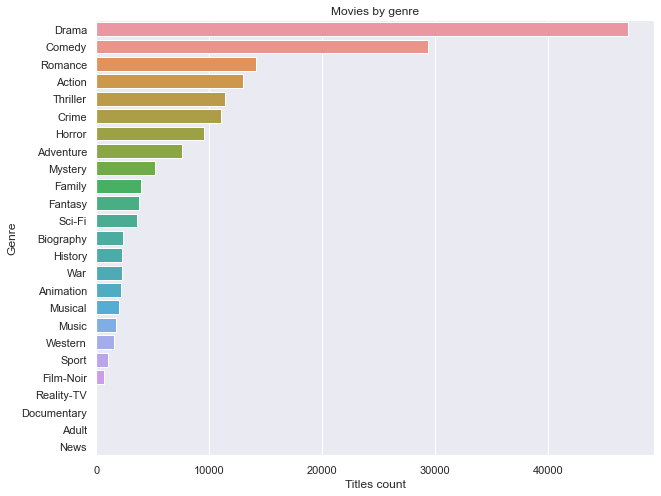

In [13]:
# Amounts of distinct genres
genres = df_movies["genre"].str.split(",").explode().str.strip()

# Plotting the visualization
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.countplot(y=genres, order=genres.value_counts().index)
ax.set_title("Movies by genre")
ax.set_xlabel("Titles count")
ax.set_ylabel("Genre")
plt.show()

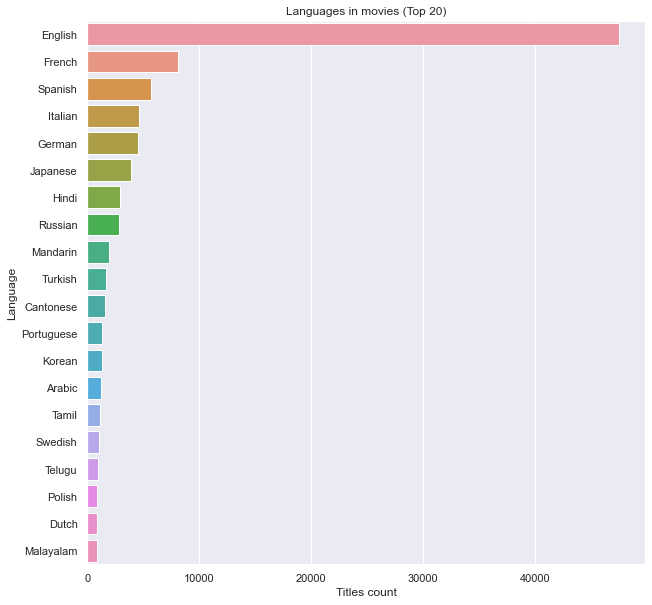

In [14]:
# Amounts of distinct languages
languages = df_movies["language"].str.split(",").explode().str.strip()

# Plotting the visualization
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.countplot(y=languages, order=languages.value_counts().iloc[:20].index)
ax.set_title("Languages in movies (Top 20)")
ax.set_xlabel("Titles count")
ax.set_ylabel("Language")
plt.show()

In [15]:
# Comparison of `title` vs. `original_title`
df_movies[df_movies["title"]!=df_movies["original_title"]][["title", "original_title"]].sample(5)

,title,original_title
46658,The Giver - Il mondo di Jonas,The Giver
59297,Senza freni,Premium Rush
3062,Cavalca e spara,Overland Stage Raiders
23887,Furia assassina,Evil Laugh
499,Il pensionante,The Lodger: A Story of the London Fog


#### Commentary
  * `title` seems to be an Italian localized movie title
  * `original_title` seems to be a title in the country of origin
  * `date_published` needs to be converted to _datetime_ type
  * `genre` multiple values are possible (up to 3)
  * `country` multiple values are possible (up to 3)
    * sparsity = 0.074544%
  * `language`:
    * Contains both `NaN` and `None`. We should learn the difference.
      * sparsity = 0.970241%
      * amount of `None`?
    * Maximum amount of languages is 18!
      * Title="Visions of Europe"
      * Languages = "Danish, German, Portuguese, Slovak, Swedish, English, Greek, Italian, Lithuanian, Polish, Dutch, French, Luxembourgish, Slovenian, Turkish, Czech, Spanish, Maltese"
  * `director` multiple values are possible (up to 2)
    * sparsity = 0.101334%
  * `writer` multiple values are possible (up to 2)
    * sparsity = 1.830994%
  * `production_company` multiple values are possible (up to 3)
    * sparsity = 5.188981%
  * `actors` multiple values are possible (up to 16)
    * sparsity = 0.080368%
  * `description`
    * sparsity = 2.463456%
  * `budget`, `usa_gross_income`, `worlwide_gross_income`, `metascore`:
    * have all high sparsity
    * have all little rational relevance with _genre_
    * can be dropped
  * `reviews_from_users` and `reviews_from_critics`
    * have small sparsity
    * have little rational relevance with _genre_
    * elimination to be considered


### Cast

In [16]:
# df_names.info()

#### Commentary
  * `height`
    * sparsity = 84.991518%
  * `bio`
    * sparsity = 31.241330%
    * this field might have some interesting information value
  * `birth_details` and `date_of_birth`
    * sparsity = 62.845098%
  * `place_of_birth`
    * sparsity = 65.068776%
  * `death_details` and `date_of_death`
    * sparsity = 86.586386%
  * `place_of_death`
    * sparsity = 87.558825%
  * `reason_of_death`
    * sparsity = 92.377018%
  * `spouses_string`
    * sparsity = 84.766128%
  

### Principals

In [17]:
# df_principals.info()

#### Commentary

This data set provides relations between _movie titles_ and _cast_.

Features:
  * `ordering` provides order of importance in the movie
  * `category` of the job done by the cast member
  * `job` - specific job done by the cast member
    * sparsity = 74.538876%
  * `characters` - name of the character played
    * sparsity = 59.206380%

### Ratings

In [18]:
# df_ratings.info()

#### Commentary

This data set provides rating information on all titles.

Most of the features here have very low sparsity, which makes it possible to include them in the training set. Following features have considerable sparsity:
  * `allgenders_0age_avg_vote` and `allgenders_0age_votes` - sparsity = 61.144954%
  * `males_0age_avg_vote` and `males_0age_votes` - sparsity = 68.072914%
  * `females_0age_avg_vote` and `females_0age_votes` - sparsity = 74.239124%

However, even missing rating demographics could provide an information. The rationale stands that young viewers are not interested in certain titles. It is necessary to prove that the lack of the rating data is caused by this reason.


### DB Model

The relationships between individual entities is detected as follows:
 * movie to rating (1 to 1)
 * movie to principals (1 to N)
 * cast to principals (1 to N)

The exact cardinalities were deducted by doing left joins and checking out missing keys:

In [19]:
# Left join from movies to principals
# movie_principals = pd.merge(left=df_movies, right=df_principals, on="imdb_title_id", how="left")

# Checking out missing keys on the right side ()
# movie_principals["imdb_name_id"].isna().sum()

In [20]:
# Getting a list of the nine movies without crew
# movie_principals[movie_principals["imdb_name_id"].isna()]

In [21]:
# Making sure there's no principal in the first "Friends: The One with the Anniversary" movie
# df_principals[df_principals["imdb_title_id"]=="tt10764458"]

In [22]:
# Doing left join from cast members to principals
# cast_principals = pd.merge(left=df_names, right=df_principals, on="imdb_name_id", how="left")

# Checking out missing keys on the right side ()
# cast_principals["imdb_title_id"].isna().sum()

#### Conclusion

Cardinality between _movies_ and _principals_ is 1:N (optional) with missing principals for 9 movie titles.  
Cardinality between _cast_ and _principals is 1:M (mandatory).

![IMDb database model](db-model.png)

### Merger of the datasets

Datasets that are in 1:1 relationship are easy to be merged - an inner join can be used. That is valid for relationship between _movies_ and their _ratings_.

The real challenge here is to merge _movies_ with _principals_ and consecutively with _cast_.

In [23]:
# Cleanup of memory in DeepNote
# del cast_principals
# del movie_principals
# del df

In [24]:
# Making big df

# Joining movies with ratings
# df1 = pd.merge(left=df_movies, right=df_ratings, on="imdb_title_id", how="inner")

# Joining with the principals
# df2 = pd.merge(left=df1, right=df_principals, on="imdb_title_id", how="inner")

# Joining with the cast
# df = pd.merge(left=df2, right=df_names, on="imdb_name_id", how="inner")

# Cleanup of the memory
# del df1
# del df2

# Info on the result
# df.info()

In [25]:
# df.shape

In [26]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    # print(df.isna().sum())

### Initial feature selection

In this part we'll decide which features we're going to keep and remove based on sparsity and potential information value:

#### Movies

Following features will drop out due to high sparsity:
  * `budget`                   (sparsity = 72.383670%)
  * `usa_gross_income`         (sparsity = 82.148972%)
  * `worlwide_gross_income`    (sparsity = 63.873974%)
  * `metascore`                (sparsity = 84.502941%)

We will remove technical field that is the key:
  * `imdb_title_id`

Also we will remove `date_published` because it's a redundant information and if there are some discrepancies, they relate to the viewer of the IMDb site. Source: [article in IMDb Help](https://help.imdb.com/article/contribution/titles/release-dates/GVUUDEPJNAW6G35P#)

#### Cast

We will remove technical field:
  * `imdb_name_id`

Redundant information:
  * `birth_details`
    * this one is redundant as it contains information from `date_of_birth` and `place_of_birth`
 * `death_details`
    * this one is redundant as it contains information from `date_of_death` and `place_of_death`

Rows removal:
  *  We decided to remove all rows that don't have `bio` provided. The birth information is usually provided in `bio`.

And following fields due to high sparsity:
  * `height`                            (sparsity = 84.991518%)
  * `date_of_birth`                     (sparsity = 62.845098%)
  * `place_of_birth`                    (sparsity = 65.068776%)
  * `date_of_death`                     (sparsity = 86.586386%)
  * `place_of_death`                    (sparsity = 87.558825%)
  * `reason_of_death`                   (sparsity = 92.377018%)
  * `spouses_string`                    (sparsity = 84.766128%)
  
#### Principals



In [27]:
# df["bio"].sample(10)

In [28]:
# df.loc[      (df["date_of_birth"].isna())  &  (df["bio"].isna()),   ["date_of_birth", "bio"] ]

## Modeling strategy

As the entire project work is very challenging, we decided to split the dataset domains and train the particular models separately.  
I.e. there will be separate models for:
* movie domain (`df_movies` dataset) (__Peter and Emese__)
* ratings domain (`df_ratings` dataset) (__Roman__)
* cast domain (`df_principals` and `df_names` dataset) (__Ilia__)

## Simple model

The initial step will be to create a simple model. Each movie can have up to 3 genres in a target variable, which makes it a _multi-label_ problem.

In this step we're going to workaround this by exploding the _list_ in the `genre` into multiple title rows, giving the model some uncertainty.  

The validation function would be the _presence_ of the predicted value in the test set value result.

The simple model will be trained upon a movies dataframe, that is `df_movies`.

### Data wrangling

In [29]:
# The movies domain DataFrame

# We'll copy it, so we can work on a separate DataFrame
movies = df_movies.copy()

movies

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,...,"Blanche Bayliss, William Courtenay, Chauncey Depew",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Bella Cola, Will Coyne, Sam Crewes, Jack Ennis, John Forde, Vera Linden, Mr. Marshall, Mr. McKenzie, Frank Mills, Ollie Wilson",True story of notorious Australian outlaw Ned Kelly (1855-80).,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helsengreen, Emil Albes, Hugo Flink, Mary Hagen","Two men of high rank are both wooing the beautiful and famous equestrian acrobat Stella. While Stella ignores the jeweler Hirsch, she accepts Count von Waldberg's offer to follow her home, ...",5.8,188,NaN,NaN,NaN,NaN,5.0,2.0
3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,"Helen Gardner, Pearl Sindelar, Miss Fielding, Miss Robson, Helene Costello, Charles Sindelar, Mr. Howard, James R. Waite, Mr. Osborne, Harry Knowles, Mr. Paul, Mr. Brady, Mr. Corker",The fabled queen of Egypt's affair with Roman general Marc Antony is ultimately disastrous for both of them.,5.2,446,$ 45000,NaN,NaN,NaN,25.0,3.0
4,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",...,"Salvatore Papa, Arturo Pirovano, Giuseppe de Liguoro, Pier Delle Vigne, Augusto Milla, Attilio Motta, Emilise Beretta",Loosely adapted from Dante's Divine Comedy and inspired by the illustrations of Gustav Doré the original silent film has been restored and has a new score by Tangerine Dream.,7.0,2237,NaN,NaN,NaN,NaN,31.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85850,tt9908390,Le lion,Le lion,2020,2020-01-29,Comedy,95,"France, Belgium",French,Ludovic Colbeau-Justin,...,"Dany Boon, Philippe Katerine, Anne Serra, Samuel Jouy, Sophie Verbeeck, Carole Brana, Benoît Pétré, Aksel Ustun, Mathieu Lardot, Olivier Sa, Julien Prevost, Antoine Mathieu, David Ban, Stan, Guillaume Clémencin","A psychiatric hospital patient pretends to be crazy. In charge of caring for this patient, a caregiver will begin to doubt the mental state of his ""protégé"".",5.3,398,NaN,NaN,$ 3507171,NaN,NaN,4.0
85851,tt9911196,De Beentjes van Sint-Hildegard,De Beentjes van Sint-Hildegard,2020,2020-02-13,"Comedy, Drama",103,Netherlands,"German, Dutch",Johan Nijenhuis,...,"Herman Finkers, Johanna ter Steege, Leonie ter Braak, Stef Assen, Annie Beumers, Jos Brummelhuis, Reinier Bulder, Daphne Bunskoek, Karlijn Koel, Karlijn Lansink, Marieke Lustenhouwer, Jan Roerink, Ferdi Stofmeel, Aniek Stokkers, Belinda van der Stoep","A middle-aged veterinary surgeon believes his wife pampers him too much. In order to get away from her, he fakes the onset of dementia.",7.7,724,NaN,NaN,$ 7299062,NaN,6.0,4.0
85852,tt9911774,Padmavyuhathile Abhimanyu,Padmavyuhathile Abhimanyu,2019,2019-03-08,Drama,130,India,Malayalam,Vineesh Aaradya,...,"Anoop Chandran, Indrans, Sona Nair, Simon Britto Rodrigues",NaN,7.9,265,NaN,NaN,NaN,NaN,NaN,NaN
85853,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,2019-03-15,"Drama, Family",98,Turkey,Turkish,Ahmet Faik Akinci,...,"Ahmet Faik Akinci, Belma Mamati, Metin Keçeci, Burhan Sirmabiyik, Orhan Aydin, Tevfik Yapici, Yusuf Eksi, Toygun Ates, Aziz Özuysal, Dilek Ölekli, Arcan Bunial, Seval Hislisoy, Ergül Çolakoglu, Gülçin Ugur, Ibrahim Balaban",NaN,6.4,194,NaN,NaN,$ 2833,Na

Now as mentioned before, we'll remove the columns with high sparsity, so we end up with cleaner DataFrame.

In [30]:
# Removing technical columns:
# - imdb_title_id

# movies.drop(columns=["imdb_title_id"], inplace=True)

# Removing columns that have high sparsity:
# - budget                   72.383670
# - usa_gross_income         82.148972
# - worlwide_gross_income    63.873974
# - metascore                84.502941

movies.drop(columns=["budget",
                    "usa_gross_income",
                    "worlwide_gross_income",
                    "metascore",], inplace=True)

# Removing column date_published based on earlier decision (see above in notebook)
movies.drop(columns=["date_published"], inplace=True)

print(movies.shape)

movies.isna().sum()

(85855, 17)


imdb_title_id               0
title                       0
original_title              0
year                        0
genre                       0
duration                    0
country                    64
language                  833
director                   87
writer                   1572
production_company       4455
actors                     69
description              2115
avg_vote                    0
votes                       0
reviews_from_users       7597
reviews_from_critics    11797
dtype: int64

So the columns with the highest sparsity are gone, the technical ones as well. The dataframe looks nicer. However, it's not the final state.

### Data cleaning

By inspection of the columns we found that the `year` feature was imported as `object` dtype. 

In [31]:
# Changing `year` into a datetime object
try:
    movies["year"] = pd.to_datetime(movies["year"], format="%Y")
except Exception as e:
    print(e)

time data 'TV Movie 2019' does not match format '%Y' (match)


When trying to change the dtype to datetime, following warning occurred:

```python
ValueError: time data 'TV Movie 2019' does not match format '%Y' (match)
```

Further check has revealed that there's just one movie that fails the match:


In [32]:
# Finding all values in `year` that don't match with "[0-9]{4}"
movies.loc[~movies["year"].str.match("[0-9]{4}"), "year"]

83917    TV Movie 2019
Name: year, dtype: object

Following cell will fix the issue. We tried first to make it a `datetime` dtype, but that will make the value on January 1st that year.
For the simplification we rather made it `int64` dtype, which satisfies the purpose.

In [33]:
# Fix the `year` feature by finding a year in the value using regex "[0-9]{4}" in a named group (P<year>)
#   then replace the original value with it
#   and store it as "int64" dtype
movies["year"] = movies["year"].str.extract(".*(?P<year>[0-9]{4}).*").astype("int64")

In [34]:
movies.head(5)

,imdb_title_id,title,original_title,year,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey Depew",The adventures of a female reporter in the 1890s.,5.9,154,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,"Biography, Crime, Drama",70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Bella Cola, Will Coyne, Sam Crewes, Jack Ennis, John Forde, Vera Linden, Mr. Marshall, Mr. McKenzie, Frank Mills, Ollie Wilson",True story of notorious Australian outlaw Ned Kelly (1855-80).,6.1,589,7.0,7.0
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,Drama,53,"Germany, Denmark",NaN,Urban Gad,"Urban Gad, Gebhard Schätzler-Perasini",Fotorama,"Asta Nielsen, Valdemar Psilander, Gunnar Helsengreen, Emil Albes, Hugo Flink, Mary Hagen","Two men of high rank are both wooing the beautiful and famous equestrian acrobat Stella. While Stella ignores the jeweler Hirsch, she accepts Count von Waldberg's offer to follow her home, ...",5.8,188,5.0,2.0
3,tt0002101,Cleopatra,Cleopatra,1912,"Drama, History",100,USA,English,Charles L. Gaskill,Victorien Sardou,Helen Gardner Picture Players,"Helen Gardner, Pearl Sindelar, Miss Fielding, Miss Robson, Helene Costello, Charles Sindelar, Mr. Howard, James R. Waite, Mr. Osborne, Harry Knowles, Mr. Paul, Mr. Brady, Mr. Corker",The fabled queen of Egypt's affair with Roman general Marc Antony is ultimately disastrous for both of them.,5.2,446,25.0,3.0
4,tt0002130,L'Inferno,L'Inferno,1911,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",Dante Alighieri,Milano Film,"Salvatore Papa, Arturo Pirovano, Giuseppe de Liguoro, Pier Delle Vigne, Augusto Milla, Attilio Motta, Emilise Beretta",Loosely adapted from Dante's Divine Comedy and inspired by the illustrations of Gustav Doré the original silent film has been restored and has a new score by Tangerine Dream.,7.0,2237,31.0,14.0


Now we'll remove individual records. In this way we're going to clean all the rows which contain `NaN`.

In [35]:
movies.dropna(inplace=True)

In [36]:
movies.shape

(65516, 17)

Finally we're going to implement our _simple model_ strategy, which:
 * will filter out all movies that are not labeled with any of our considered genres:
    * Drama
    * Comedy
    * Romance

In [37]:
# These genres are considered now
considered_genres = ["Drama", "Comedy", "Romance"]

# Filtering out the rest of the genres out of the _genre_ list
movies["genre"] = movies["genre"].str.split(", ")
movies["genre"] = movies["genre"].apply(lambda genre_list: list(filter(lambda genre: genre in considered_genres, genre_list)))

In [38]:
movies.shape

(65516, 17)

After the filtering out of these genres, we ended up with a Dataframe which contains following genre combinations:

In [39]:
try:
    print(movies["genre"].value_counts())
except Exception as e:
    print(e)

[Drama]                     24101
[]                          14203
[Comedy]                    10873
[Comedy, Drama]              5357
[Drama, Romance]             4925
[Comedy, Romance]            2781
[Comedy, Drama, Romance]     1890
[Romance]                    1080
[Drama, Comedy]               124
[Romance, Drama]               62
[Romance, Comedy]              39
[Comedy, Romance, Drama]       27
[Drama, Comedy, Romance]       24
[Romance, Comedy, Drama]       15
[Drama, Romance, Comedy]       13
[Romance, Drama, Comedy]        2
Name: genre, dtype: int64


Now we'll remove all movies that has empty list in `genre`:

In [40]:
# By treating list with `.str.len()` we can find its length
movies["genre"].str.len().value_counts()

1    36054
0    14203
2    13288
3     1971
Name: genre, dtype: int64

In [41]:
#  Keeping everything that has non-zero length
movies = movies[movies["genre"].str.len()>0]

# Check:
try:
    print(movies["genre"].value_counts())
except Exception as e:
    print(e)

[Drama]                     24101
[Comedy]                    10873
[Comedy, Drama]              5357
[Drama, Romance]             4925
[Comedy, Romance]            2781
[Comedy, Drama, Romance]     1890
[Romance]                    1080
[Drama, Comedy]               124
[Romance, Drama]               62
[Romance, Comedy]              39
[Comedy, Romance, Drama]       27
[Drama, Comedy, Romance]       24
[Romance, Comedy, Drama]       15
[Drama, Romance, Comedy]       13
[Romance, Drama, Comedy]        2
Name: genre, dtype: int64


In [42]:
movies.head(5)

,imdb_title_id,title,original_title,year,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,[Romance],45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey Depew",The adventures of a female reporter in the 1890s.,5.9,154,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,[Drama],70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Bella Cola, Will Coyne, Sam Crewes, Jack Ennis, John Forde, Vera Linden, Mr. Marshall, Mr. McKenzie, Frank Mills, Ollie Wilson",True story of notorious Australian outlaw Ned Kelly (1855-80).,6.1,589,7.0,7.0
3,tt0002101,Cleopatra,Cleopatra,1912,[Drama],100,USA,English,Charles L. Gaskill,Victorien Sardou,Helen Gardner Picture Players,"Helen Gardner, Pearl Sindelar, Miss Fielding, Miss Robson, Helene Costello, Charles Sindelar, Mr. Howard, James R. Waite, Mr. Osborne, Harry Knowles, Mr. Paul, Mr. Brady, Mr. Corker",The fabled queen of Egypt's affair with Roman general Marc Antony is ultimately disastrous for both of them.,5.2,446,25.0,3.0
4,tt0002130,L'Inferno,L'Inferno,1911,[Drama],68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",Dante Alighieri,Milano Film,"Salvatore Papa, Arturo Pirovano, Giuseppe de Liguoro, Pier Delle Vigne, Augusto Milla, Attilio Motta, Emilise Beretta",Loosely adapted from Dante's Divine Comedy and inspired by the illustrations of Gustav Doré the original silent film has been restored and has a new score by Tangerine Dream.,7.0,2237,31.0,14.0
5,tt0002199,"From the Manger to the Cross; or, Jesus of Nazareth","From the Manger to the Cross; or, Jesus of Nazareth",1912,[Drama],60,USA,English,Sidney Olcott,Gene Gauntier,Kalem Company,"R. Henderson Bland, Percy Dyer, Gene Gauntier, Alice Hollister, Samuel Morgan, James D. Ainsley, Robert G. Vignola, George Kellog, J.P. McGowan","An account of the life of Jesus Christ, based on the books of the New Testament: After Jesus' birth is foretold to his parents, he is born in Bethlehem, and is visited by shepherds and wise...",5.7,484,13.0,5.0


Now we have nice and clean dataframe.

In [43]:
movies.isna().sum()

imdb_title_id           0
title                   0
original_title          0
year                    0
genre                   0
duration                0
country                 0
language                0
director                0
writer                  0
production_company      0
actors                  0
description             0
avg_vote                0
votes                   0
reviews_from_users      0
reviews_from_critics    0
dtype: int64

In [44]:
movies.shape

(51313, 17)

### Language Detection

Now we'll try to detect language in the `title`.

In [45]:
# Import of English rules
nlp = spacy.load("en_core_web_sm")

# Function to construct the LanguageDetector() with a name
def get_lang_detector(nlp, name):
    return LanguageDetector()

In [46]:
# Constructing LanguageDetector() pipeline component
Language.factory("language_detector", func=get_lang_detector)

# We're adding LanguageDetector() to the end of the Spacy NLP pipeline
nlp.add_pipe("language_detector", last=True)

# We create the function that returns the language of the document
def detect_language(text):
    # Push the text through the spacy pipeline
    doc = nlp(text)
    
    # Get the detected language (type = dict)
    detect_language = doc._.language

    # Return the detected language
    return detect_language["language"]

In [156]:
detect_language("Toto je python kodenie. Paci sa mi to.")

'sk'

In [158]:
detect_language("Donner un coup de main")

'fr'

In [157]:
detect_language("Működik a nyelv felismerő.")

'hu'

In [49]:
detect_language("Es funktionert endlich.")

'de'

In [50]:
detect_language("Yo no hablo espanol.")

'es'

In [51]:
movies["title_language"] = movies["title"].apply(detect_language)

KeyboardInterrupt: 

In [ ]:
movies.head()

,title,original_title,year,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,reviews_from_users,reviews_from_critics
0,Miss Jerry,Miss Jerry,1894,[Romance],45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey Depew",The adventures of a female reporter in the 1890s.,5.9,154,1.0,2.0
1,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,[Drama],70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Bella Cola, Will Coyne, Sam Crewes, Jack Ennis, John Forde, Vera Linden, Mr. Marshall, Mr. McKenzie, Frank Mills, Ollie Wilson",True story of notorious Australian outlaw Ned Kelly (1855-80).,6.1,589,7.0,7.0
3,Cleopatra,Cleopatra,1912,[Drama],100,USA,English,Charles L. Gaskill,Victorien Sardou,Helen Gardner Picture Players,"Helen Gardner, Pearl Sindelar, Miss Fielding, Miss Robson, Helene Costello, Charles Sindelar, Mr. Howard, James R. Waite, Mr. Osborne, Harry Knowles, Mr. Paul, Mr. Brady, Mr. Corker",The fabled queen of Egypt's affair with Roman general Marc Antony is ultimately disastrous for both of them.,5.2,446,25.0,3.0
4,L'Inferno,L'Inferno,1911,[Drama],68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",Dante Alighieri,Milano Film,"Salvatore Papa, Arturo Pirovano, Giuseppe de Liguoro, Pier Delle Vigne, Augusto Milla, Attilio Motta, Emilise Beretta",Loosely adapted from Dante's Divine Comedy and inspired by the illustrations of Gustav Doré the original silent film has been restored and has a new score by Tangerine Dream.,7.0,2237,31.0,14.0
5,"From the Manger to the Cross; or, Jesus of Nazareth","From the Manger to the Cross; or, Jesus of Nazareth",1912,[Drama],60,USA,English,Sidney Olcott,Gene Gauntier,Kalem Company,"R. Henderson Bland, Percy Dyer, Gene Gauntier, Alice Hollister, Samuel Morgan, James D. Ainsley, Robert G. Vignola, George Kellog, J.P. McGowan","An account of the life of Jesus Christ, based on the books of the New Testament: After Jesus' birth is foretold to his parents, he is born in Bethlehem, and is visited by shepherds and wise...",5.7,484,13.0,5.0


### Post-processing data exploration

Following data observation is only studying movies from following genres:
* Drama
* Comedy
* Romance

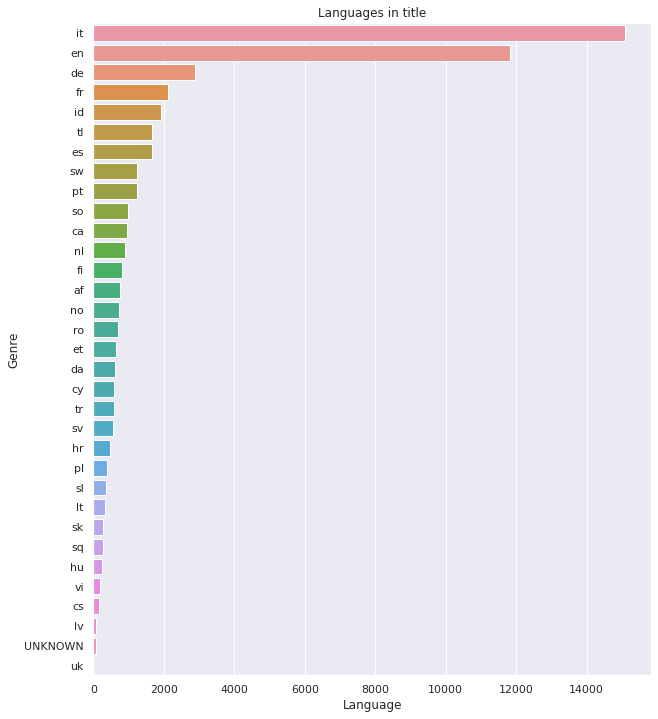

In [ ]:
# Titles with detected languages
fig, ax = plt.subplots(figsize=(10, 12))
ax = sns.countplot(data=movies, y="title_language", order=movies["title_language"].value_counts().index)
ax.set_title("Languages in title")
ax.set_xlabel("Language")
ax.set_ylabel("Genre")
plt.show()

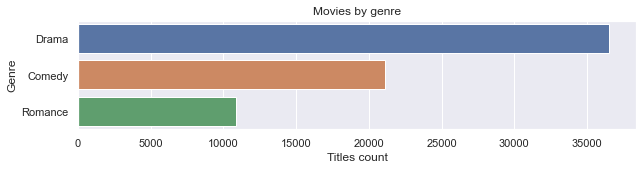

In [52]:
# Amounts of distinct genres
genres = movies["genre"].explode()

# Plotting the visualization
fig, ax = plt.subplots(figsize=(10, 2))
ax = sns.countplot(y=genres, order=genres.value_counts().index)
ax.set_title("Movies by genre")
ax.set_xlabel("Titles count")
ax.set_ylabel("Genre")
plt.show()

It is clear that the dataset is not balanced, we need to introduce __stratification__.

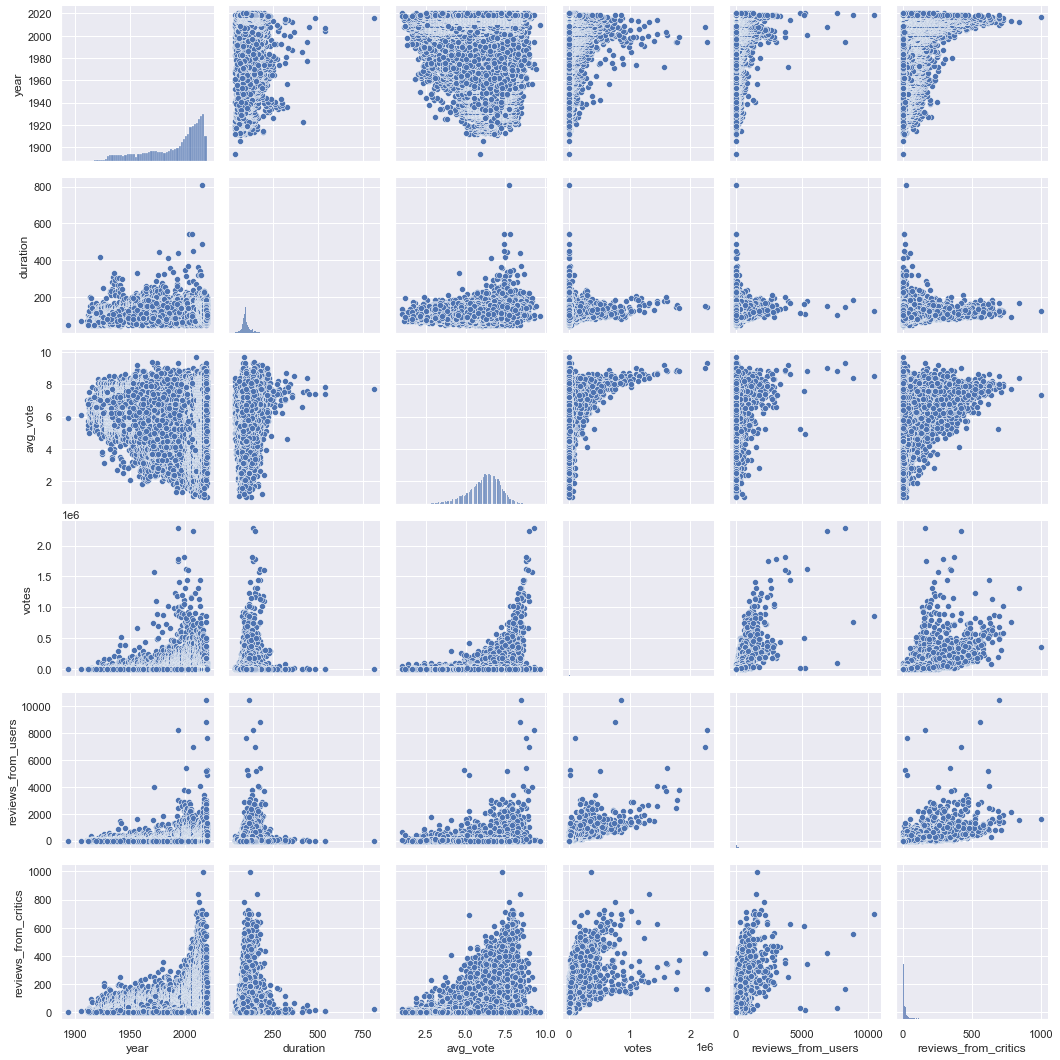

In [53]:
# Let's make pairplot from numeric features
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

movies_num = movies.select_dtypes(include=numerics)

sns.pairplot(data=movies_num)

Interesting.

There are some very intriguing patterns in the pairplot. We'll take a look at some below.

Following histogram shows how many titles from the considered genres were produced throughout the years.

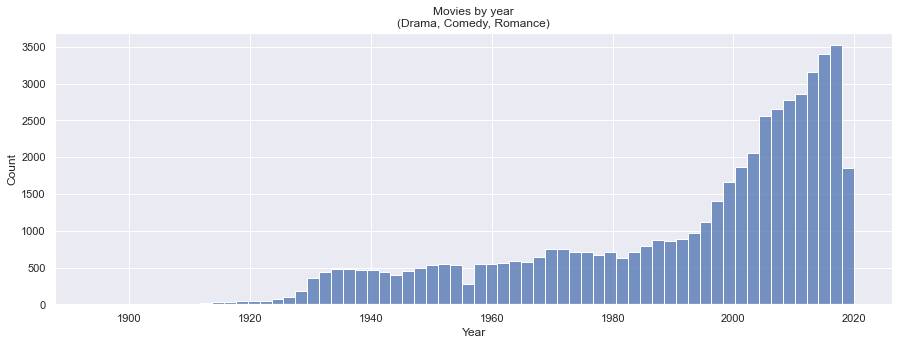

In [54]:
fig, ax = plt.subplots(figsize=(15,5))

ax = sns.histplot(data=movies_num, x="year")
ax.set_title("Movies by year\n(Drama, Comedy, Romance)")
ax.set_xlabel("Year")

plt.show()

List of top 10 movies with highest counts of votes:

In [55]:
movies[["original_title", "year", "avg_vote", "votes"]].sort_values(by="votes", ascending=False).head(10)

,original_title,year,avg_vote,votes
28453,The Shawshank Redemption,1994,9.3,2278845
48078,The Dark Knight,2008,9.0,2241615
32487,Fight Club,1999,8.8,1807440
28381,Pulp Fiction,1994,8.9,1780147
28066,Forrest Gump,1994,8.8,1755490
31279,The Lord of the Rings: The Fellowship of the Ring,2001,8.8,1619920
34127,The Lord of the Rings: The Return of the King,2003,8.9,1604280
15528,The Godfather,1972,9.2,1572674
34128,The Lord of the Rings: The Two Towers,2002,8.7,1449778
50294,Interstellar,2014,8.6,1449256


List of top 10 movies with highest votes mean.

In [56]:
movies[["original_title", "year", "avg_vote", "votes"]].sort_values(by="avg_vote", ascending=False).head(10)

,original_title,year,avg_vote,votes
58809,Hopeful Notes,2010,9.7,669
52108,Jibon Theke Neya,1970,9.4,1794
28453,The Shawshank Redemption,1994,9.3,2278845
81109,Love in Kilnerry,2019,9.3,1239
38406,Hababam Sinifi,1975,9.3,36269
15528,The Godfather,1972,9.2,1572674
38245,Maya Bazaar,1957,9.2,3813
77399,Natsamrat,2016,9.1,4880
79532,Delaware Shore,2018,9.1,507
80608,Zana,2019,9.1,4114


List of top 10 longest movies.

In [57]:
movies[["original_title", "year", "avg_vote", "votes", "duration"]].sort_values(by="duration", ascending=False).head(10)

,original_title,year,avg_vote,votes,duration
85057,La flor,2016,7.7,473,808
46153,Ebolusyon ng isang pamilyang Pilipino,2004,7.8,305,540
53877,Kagadanan sa banwaan ning mga engkanto,2007,7.4,165,540
75922,Hele sa hiwagang hapis,2016,7.4,251,485
56257,Melancholia,2008,7.4,366,450
18005,"Hitler, ein Film aus Deutschland",1977,7.6,715,442
28510,Sátántangó,1994,8.4,9024,439
333,La roue,1923,7.5,1889,418
22227,Le soulier de satin,1985,6.6,149,410
42876,La meglio gioventù,2003,8.5,20184,366


Following graph is very interesting. It shows relation between counts of votes and their mean value.

One could ask himself: "Why there's convergence to high average vote when looking from low count to high counts?"  

My hypothesis is as follows:  
There's apparent strong virality effect. If the movie popularity (by marketing hype, by movie appeal on the viewer) is high, it is given a high attention and high votes. This brings in a feedback loop effect -> better ratings, more people talk about it, more people are attracted to see it and give it more votes.
E.g. The IMDb site has a TOP N ranking list for best rated movies. IMDb users might treat this list as a "must-see" bucket list and will decide to watch movies
that are placed high on it.

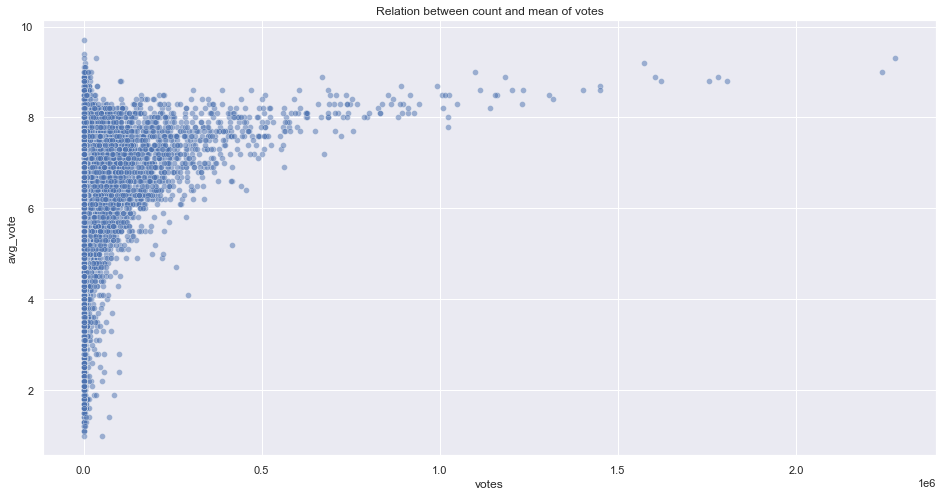

In [58]:
fig, ax = plt.subplots(figsize=(16,8))

ax = sns.scatterplot(x="votes", y="avg_vote", alpha=0.5, data=movies_num)
ax.set_title("Relation between count and mean of votes")

plt.show()

Apparently, the only features that show some correlation are:
* `votes`
* `reviews_from_users`
* `reviews_from_critics`

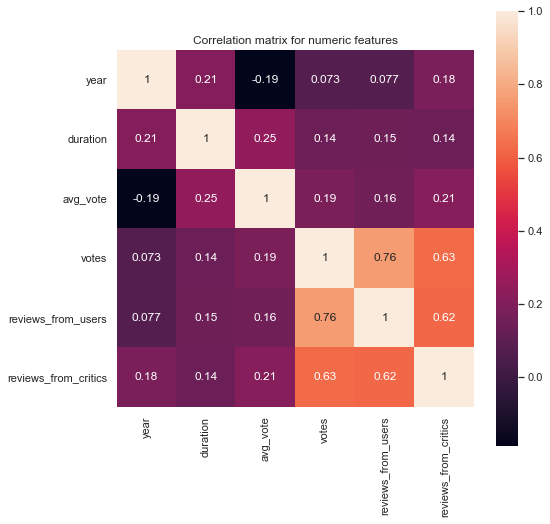

In [59]:
corr_matrix = movies_num.corr()

fig, ax = plt.subplots(figsize=(8, 8))

ax = sns.heatmap(corr_matrix, annot=True, square=True)
ax.set_title("Correlation matrix for numeric features")
plt.show()

__Fun fact:__  
We had an idea of uniqueness of the movies within the database and so we tried to find a duplicate movies based on:
* original_title
* year
* director

There result were that we actually were able to find a triple entry for seemingly the same movie:

In [60]:
# How to get movies with same
# - original_title
# - year
# - director
movies.loc[movies[["original_title", "year", "director"]].duplicated(), :].sort_values(by="original_title")

,imdb_title_id,title,original_title,year,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,reviews_from_users,reviews_from_critics
10052,tt0053115,Ningen no jôken,Ningen no jôken,1959,[Drama],181,Japan,"Japanese, Mandarin, Russian",Masaki Kobayashi,"Zenzô Matsuyama, Masaki Kobayashi",Shochiku,"Tatsuya Nakadai, Michiyo Aratama, Kokinji Katsura, Jun Tatara, Michirô Minami, Kei Satô, Kunie Tanaka, Ryôhei Uchida, Kan Yanagiya, Kenjirô Uemura, Kaneko Iwasaki, Mayumi Kurata, Taketoshi Naitô, Hideo Kidokoro, Yoshiaki Aoki","As a conscript in war-time Japan's military, a pacifist struggles to maintain his determination to keep his ideals.",8.5,4957,10.0,32.0


This is the triplet:

In [61]:
movies[movies["original_title"]=="Ningen no jôken"]

,imdb_title_id,title,original_title,year,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,reviews_from_users,reviews_from_critics
10051,tt0053114,Nessun amore è più grande,Ningen no jôken,1959,[Drama],208,Japan,"Japanese, Mandarin",Masaki Kobayashi,"Zenzô Matsuyama, Masaki Kobayashi",Ninjin Club,"Tatsuya Nakadai, Michiyo Aratama, Chikage Awashima, Ineko Arima, Keiji Sada, Sô Yamamura, Akira Ishihama, Kôji Nanbara, Seiji Miyaguchi, Tôru Abe, Masao Mishima, Eitarô Ozawa, Kôji Mitsui, Akitake Kôno, Nobuo Nakamura","A Japanese pacifist, unable to face the dire consequences of conscientious objection, is transformed by his attempts to compromise with the demands of war-time Japan.",8.5,6233,22.0,41.0
10052,tt0053115,Ningen no jôken,Ningen no jôken,1959,[Drama],181,Japan,"Japanese, Mandarin, Russian",Masaki Kobayashi,"Zenzô Matsuyama, Masaki Kobayashi",Shochiku,"Tatsuya Nakadai, Michiyo Aratama, Kokinji Katsura, Jun Tatara, Michirô Minami, Kei Satô, Kunie Tanaka, Ryôhei Uchida, Kan Yanagiya, Kenjirô Uemura, Kaneko Iwasaki, Mayumi Kurata, Taketoshi Naitô, Hideo Kidokoro, Yoshiaki Aoki","As a conscript in war-time Japan's military, a pacifist struggles to maintain his determination to keep his ideals.",8.5,4957,10.0,32.0
10823,tt0055233,Ningen no jôken,Ningen no jôken,1961,[Drama],190,Japan,"Japanese, Mandarin, Russian",Masaki Kobayashi,"Zenzô Matsuyama, Kôichi Inagaki",Ninjin Club,"Tatsuya Nakadai, Michiyo Aratama, Tamao Nakamura, Yûsuke Kawazu, Chishû Ryû, Taketoshi Naitô, Kyôko Kishida, Reiko Hitomi, Keijirô Morozumi, Kôji Kiyomura, Nobuo Kaneko, Fujio Suga, Tatsuya Ishiguro, Kazuo Kitamura, Toshio Takahara","His ideals challenged by life as a conscript in war-time Japan's military, a pacifist faces ever greater tests in his fight for survival.",8.8,4841,21.0,33.0


### Multi-label problem strategy

As we're dealing with the multi-label problem, we decided to apply following approach:
1. Features and target of the whole data set are separated into $X, y$. One record represents a movie.
2. Both objects ($X$ and $y$) would be __split into training and testing set__ as usual.
3. The $X_{train}$ would be used to _fit_ all the transforming elements of the scikit-learn `ColumnTransformer`
4. The $X_{train}$ would be joined temporarily with its $y_{train}$ to allow so-called _list explosion_  
   where records (movies) that fall into multiple studied genres (up to 3, e.g. `['Drama', 'Romance']`) would be replicated into  
   multiple lines, __one per each genre__.  
   From this point on, the $X_{train}$ is composed of records where __single record holds single unique genres AND movie__ combination.  
   By doing this we ensured that all genre labels are used for model training. 
5. The $X_{train}$ and $y_{train}$ would be separated again.
6. Both $X_{train}$ and $X_{test}$ would be transformed using main `ColumnTransformer` and converted into a shape  
   that allows model training (_CSR sparse matrix_).
7. After all these steps we have all we need to train our models.

In [62]:
# Step 1: Separation of X and y
# -----------------------------

# List of all features
features = ["title",
            "original_title",
            "year",
            "duration",
            "country",
            "language",
            "director",
            "writer",
            "production_company",
            "actors",
            "description",
            "avg_vote",
            "votes",
            "reviews_from_users",
            "reviews_from_critics"]

# The target
target = "genre"

# Making the X, y
X = movies[features].copy()
y = movies[target].copy()

In [63]:
# Step 2: Train / Test split
# --------------------------

# Performing train test split using stratification (test_size = 2000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2000, random_state=42, stratify=y)

In [64]:
# Checking the result
print(f"Training set = {X_train.shape}")
print(f"Testing set = {X_test.shape}")

Training set = (49313, 15)
Testing set = (2000, 15)


### Fitting encoders

In [65]:
# Initial setup
# -------------

# Set up list of columns that will be one-hot encoded
cols_to_oh_encode = ["country", "language", "production_company"]

# Set up list which should be vectorized
cols_to_vectorize = ["description"]

# Set up empty dict to store MultiLabelBinarizer objects
col_to_oh_encoder = {}

# Set up empty dict to store MultiLabelBinarizer objects
col_to_vectorizer = {}

In [66]:
# Fitting MLB encoders
# --------------------


# This block fits MLB encoders for all columns that need encoding
for col in cols_to_oh_encode:

    # Get all categories for one-hot encoding
    col_categories = X[col].str.split(', ').explode().unique()

    # Construct the encoder (MLB) with forced classes (from previous step)
    encoder = MultiLabelBinarizer(classes=col_categories, sparse_output=True)

    # Fit the encoder
    encoder.fit(X[col])

    # Store the encoder to the dict structure
    col_to_oh_encoder[col] = encoder

In [67]:
# Fitting TF-IDF vectorizers
# -------------------------


# This block fits TfidfVectorizers for all columns that need vectorizing
for col in cols_to_vectorize:

    # Construct the vectorizer
    vectorizer = TfidfVectorizer()

    # Fit the vectorizer
    vectorizer.fit(X_train[col])

    # Store the vectorizer instance to the dict structure
    col_to_vectorizer[col] = vectorizer

#### Functions to be used in FunctionTransformer

In [68]:
# Preparing functions for FunctionTransformers
# --------------------------------------------



# split_strings_to_lists
# ----------------------

# This function will split a text delimited by comma (,) to a list
def split_strings_to_lists(input_df, delimiter):
    
    # Function that splits the string to a list
    def str_split(input_str, delimiter):
        return input_str.split(delimiter)

    # Making a copy of the input_df (to prevent doing changes on the same object)
    output_df = input_df.copy()

    # Transform all series
    for series in output_df.columns:
        output_df[series] = output_df[series].apply(str_split, args=(delimiter,))
    
    return output_df



# lemmatize_df
# ------------

# Function to cleanup and lemmatize text from DataFrame columns
def lemmatize_df(input_df):

    output_df = input_df.copy()

    # This is embedded function that lemmatizes single text string
    def lemmatize_this(text):

        # Create Doc - a sequence of Tokens
        doc = nlp(text)

        # Removing punct, whitespace and stop words and to lowercase, too
        return " ".join([token.lemma_.lower() for token in doc if not(token.is_punct) and not(token.is_stop) and not(token.is_space)])
    
    # The function above is now applied on every element of every column in the given DataFrame
    for series in output_df.columns:
        output_df[series] = output_df[series].apply(lemmatize_this)

    return output_df



# df_to_csr_converter
# -------------------

# This simple function takes a dataframe, converts it to csr_matrix and returns it
def df_to_csr_converter(input_df):
    output_df = input_df.to_numpy()
    output_csr = csr_matrix(output_df)
    return output_csr



# multi_label_binarizer
# ---------------------

# Define function that takes DataFrame with all columns to be one-hot encoded
# It will return sparse matrix with one-hot encoded columns from the input DataFrame
def multi_label_binarizer(input_df):
    return hstack([col_to_oh_encoder[series].transform(input_df[series]) for series in input_df.columns])



# text_vectorizer
# ---------------

# Define function that will vectorize all columns from given DataFrame
# and return sparse matrix
def text_vectorizer(input_df):
    return hstack([col_to_vectorizer[series].transform(input_df[series]) for series in input_df.columns])


### Building Column Transformer

In [69]:
# Setting up whole Column Transformer
# -----------------------------------

# This transformer converts columns to sparse format
csr_transformer = FunctionTransformer(func=df_to_csr_converter,
                                      validate=False)

# Sub-pipelines
# -------------

# SPLITTER pipeline,
# which splits comma-delimited strings into list
# then one-hot encodes the resulting list into many columns
splitter_pipe = make_pipeline(FunctionTransformer(func=split_strings_to_lists,
                                                   kw_args={"delimiter": ", "},
                                                   validate=False),
                              FunctionTransformer(func=multi_label_binarizer,
                                                   validate=False))

# LEMMER pipeline,
# which lemmatizes string
# then TF-IDF vectorizes them into many columns
lemmer_pipe   = make_pipeline(FunctionTransformer(func=lemmatize_df,
                                                   validate=False),
                              FunctionTransformer(func=text_vectorizer,
                                                   validate=False))                              


# MAIN Column Transformer
# -----------------------

# This column transformer combines all above defined FunctionTransformers
# and sub-pipelines into one structure where each feature gets individual care.
main_ct = make_column_transformer(
                                    (TfidfVectorizer(), "title"),
                                    (TfidfVectorizer(), "original_title"),
                                    (csr_transformer,  ["year",
                                                        "duration"]),
                                    (splitter_pipe,    cols_to_oh_encode),
                                    (lemmer_pipe,      cols_to_vectorize),
                                    (csr_transformer,  ["avg_vote",
                                                        "votes",
                                                        "reviews_from_users",
                                                        "reviews_from_critics"]),
                                    remainder="drop"
                                    )

After all sub-components are created and fitted, the next step is to _fit_ the main `ColumnTransformer`:

In [70]:
# Fitting on X_train
# ------------------

# Takes ~ 9 minutes
main_ct.fit(X_train)

ColumnTransformer(transformers=[('tfidfvectorizer-1', TfidfVectorizer(),
                                 'title'),
                                ('tfidfvectorizer-2', TfidfVectorizer(),
                                 'original_title'),
                                ('functiontransformer-1',
                                 FunctionTransformer(func=<function df_to_csr_converter at 0x0000018A7BA14670>),
                                 ['year', 'duration']),
                                ('pipeline-1',
                                 Pipeline(steps=[('functiontransformer-1',
                                                  FunctionTransformer(func=<function sp...
                                                  FunctionTransformer(func=<function lemmatize_df at 0x0000018A7BA149D0>)),
                                                 ('functiontransformer-2',
                                                  FunctionTransformer(func=<function text_vectorizer at 0x0000018A7BA147

### "Exploding" the training set

In [71]:
# "Exploding genre" strategy
# --------------------------

# Steps 1 to 3 are done at this point

# Step 4: Temporary joing of the training set to allow exploding
# --------------------------------------------------------------
movies_train = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)

# Actual genre explosion
movies_train = movies_train.explode("genre", ignore_index=True)

In [72]:
# Step 5: Separation of the training X and y again
# ------------------------------------------------
X_train = movies_train[features]
y_train = movies_train[target]

X_train.shape, y_train.shape

((65871, 15), (65871,))

In [73]:
# Step 6: Transformation and conversion to CSR matrix
# ---------------------------------------------------

# This step takes ~ 13 min to complete
X_train_csr = main_ct.transform(X_train)

# This step takes ~ 35 seconds to complete
X_test_csr = main_ct.transform(X_test)

In [74]:
X_train_csr

<65871x146842 sparse matrix of type '<class 'numpy.float64'>'
	with 1928674 stored elements in Compressed Sparse Row format>

In [75]:
X_test_csr

<2000x146842 sparse matrix of type '<class 'numpy.float64'>'
	with 55803 stored elements in Compressed Sparse Row format>

### Training the model

In [91]:
model = LogisticRegression(max_iter=1000,
                         C=0.1,
                         multi_class='ovr',
                         class_weight='balanced',
                         solver='saga',
                         verbose=1)

model.fit(X_train_csr, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 142 seconds


C:\Users\pivanov\Apps\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 116 seconds


C:\Users\pivanov\Apps\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 120 seconds


C:\Users\pivanov\Apps\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.3min finished


LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000,
                   multi_class='ovr', solver='saga', verbose=1)

In [92]:
y_test_pred = model.predict(X_test_csr)

In [93]:
# custom_accuracy
# ---------------
# Function that computes the accuracy score in a multi-class problem 
def custom_accuracy(pred_series, true_series):
    return true_series.reset_index(drop=True).reset_index().apply(lambda row: pred_series[row['index']] in row['genre'], axis=1).mean()

custom_accuracy(y_test_pred, y_test)

0.308

### Predictions output

In [79]:
# We need to populate a column in a dataframe with predictions
movies_csr = main_ct.transform(movies[features])

In [122]:
probas_df = pd.DataFrame(model.predict_proba(movies_csr), columns=model.classes_)
probas_df.rename(columns={"Comedy": "Comedy_proba",
                          "Drama" : "Drama_proba",
                          "Romance" : "Romance_proba" }, inplace=True)

In [123]:
probas_df

,Comedy_proba,Drama_proba,Romance_proba
0,0.333208,0.332889,0.333903
1,0.333055,0.333041,0.333904
2,0.332774,0.333236,0.333991
3,0.333060,0.333207,0.333733
4,0.333076,0.333021,0.333903
...,...,...,...
51308,0.332825,0.333155,0.334020
51309,0.332936,0.333087,0.333978
51310,0.332860,0.333125,0.334015
51311,0.331587,0.335396,0.333017


In [101]:
model.predict_proba(movies_csr)[:][0]

#model.classes_

array([0.33320751, 0.33288945, 0.33390304])

In [112]:
movies["Drama"] = model.predict(movies_csr) == "Drama"
movies["Comedy"] = model.predict(movies_csr) == "Comedy"
movies["Romance"] = model.predict(movies_csr) == "Romance"



<ipython-input-112-51aa477b2293>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies["Drama"] = model.predict(movies_csr) == "Drama"
<ipython-input-112-51aa477b2293>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies["Comedy"] = model.predict(movies_csr) == "Comedy"
<ipython-input-112-51aa477b2293>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

In [124]:
mov_cols_list=["imdb_title_id", "Drama", "Comedy", "Romance"]
proba_cols_list=["Drama_proba", "Comedy_proba", "Romance_proba"]

df1=movies[mov_cols_list].copy()
df2=probas_df[proba_cols_list].copy()

df1.shape, df2.shape

df1.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)

predictions_df = pd.concat( [df1, df2], axis=1) 

In [125]:
predictions_df

,imdb_title_id,Drama,Comedy,Romance,Drama_proba,Comedy_proba,Romance_proba
0,tt0000009,False,False,True,0.332889,0.333208,0.333903
1,tt0000574,False,False,True,0.333041,0.333055,0.333904
2,tt0002101,False,False,True,0.333236,0.332774,0.333991
3,tt0002130,False,False,True,0.333207,0.333060,0.333733
4,tt0002199,False,False,True,0.333021,0.333076,0.333903
...,...,...,...,...,...,...,...
51308,tt9887580,False,False,True,0.333155,0.332825,0.334020
51309,tt9890308,False,False,True,0.333087,0.332936,0.333978
51310,tt9894440,False,False,True,0.333125,0.332860,0.334015
51311,tt9898858,True,False,False,0.335396,0.331587,0.333017


In [131]:
z = movies["imdb_title_id"]

In [135]:



# Performing train test split using stratification (test_size = 2000)
z_train, z_test, y_train, y_test = train_test_split(z, y, test_size=2000, random_state=42, stratify=y)

In [150]:
probas_df

,Comedy_proba,Drama_proba,Romance_proba
0,0.333208,0.332889,0.333903
1,0.333055,0.333041,0.333904
2,0.332774,0.333236,0.333991
3,0.333060,0.333207,0.333733
4,0.333076,0.333021,0.333903
...,...,...,...
51308,0.332825,0.333155,0.334020
51309,0.332936,0.333087,0.333978
51310,0.332860,0.333125,0.334015
51311,0.331587,0.335396,0.333017


In [153]:
predictions_df["is_train"]=predictions_df["imdb_title_id"].isin(z_train)

In [155]:
predictions_df.to_csv("Peter_predictions.csv")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=32be0e9c-412e-4c8a-8f59-b8d135f80a0a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>